In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.stats.api as sms
from datetime import datetime

In [2]:

def myfilter(df, Q, W, T):
    return df[(np.isclose(df["quantile"], Q)) & (np.isclose(df["window_lengths"], W))
              & (np.isclose(df["time_merge_blocks"], T))]

def dropnas(df, subset=["onset_psg", "offset_psg"]):
    return df.dropna(subset=subset)

def get_mse(df, results=["mse_psg_hr"]):
    mse_results = df.groupby("exp_id")[[*results, "quantile", "window_lengths", "time_merge_blocks"]].mean()
    mse_exp_ids = mse_results.sort_values(by=results[0], ascending=True)
    return mse_exp_ids

def transform_datetime(df):
    on_off_set_keys = [k for k in df.keys() if k.startswith("onset")]
    on_off_set_keys += [k for k in df.keys() if k.startswith("offset")]
    
    for col in on_off_set_keys:
        df[col] = pd.to_datetime(df[col])
    return df

def ci95(values, ci=0.95):
    d = sms.DescrStatsW(values)
    mean_minus_ci, mean_plus_ci = d.tconfint_mean(alpha=ci)
    return d.mean, mean_plus_ci - d.mean


def time_deviation(df, col1, col2):
    # Version with mean +- std:
    #return (df[col1] - df[col2]).mean().total_seconds()/60., (df[col1] - df[col2]).std().total_seconds()/60.
    # Version with mean +- 95CI:
    return ci95((df[col1] - df[col2]).dt.total_seconds()/60.)
    

def get_hparams(df):
    return df["quantile"].values[0], df["window_lengths"].values[0], df["time_merge_blocks"].values[0]

def get_by_expid(df, expid):
    return df[df["exp_id"] == expid]

def get_diary(diary, pid):
    return diary[diary["pid"] == pid]


def fix_mesa_missing_diaries(df_in, diff):
    df = df_in.copy()
    mesa_diary = pd.read_csv("./data/diaries/mesa_diary.csv")
    mesa_diary["pid"] = mesa_diary["pid"].astype(str)
    mesa_diary["sleep_onset"] = pd.to_datetime(mesa_diary["sleep_onset"])
    mesa_diary["sleep_offset"] = pd.to_datetime(mesa_diary["sleep_offset"])

    missing = df[diff.isnull()]
    for rid, row in missing.iterrows():

        pid = str(row["pid"])
        onset = row["onset_diary"]
        offset = row["offset_diary"]

        #print(rid, onset, offset)

        # only onset is null
        if pd.isnull(onset) and not pd.isnull(offset):
            d = get_diary(mesa_diary, pid)
            new_onset = d[d["sleep_offset"] == offset]["sleep_onset"].values[0]
            df.loc[rid, "onset_diary"] = new_onset

        # only offset is null
        if pd.isnull(offset) and not pd.isnull(onset):
            d = get_diary(mesa_diary, pid)
            new_offset = d[d["sleep_onset"] == onset]["sleep_offset"].values[0]
            df.loc[rid, "offset_diary"] = new_offset
            
    return df

def calculate_table(df, exptype, inverse=False, labels=True):
    a, b = exptype.split("_")
    if inverse:
        tmp = a
        a = b
        b = tmp
    
    print("Comparing %s and %s" % (a,b))
    best_exp = get_mse(df, results=["mse_" + exptype]).head(1)
    Q, W, T = get_hparams(best_exp)
    if labels:
        print("BEST parameters: Q: %.2f, W: %.2f, T: %.2f" % (Q, W, T))

    best = myfilter(df, Q, W, T).copy()

    best["tst_" + a] = best["offset_" + a] - best["onset_" + a]
    best["tst_" + b] = best["offset_" + b] - best["onset_" + b]

    if labels:
        print("TST: %.2f \pm %.2f" % time_deviation(best, "tst_" + a, "tst_" + b))
        print("MSE: %.2f \pm %.2f" % ci95(best["mse_" + exptype].values))
        print("Cohens: %.2f \pm %.2f" % ci95(best["cohens_" + exptype].values))

        print("ONSET: %.2f \pm %.2f" % time_deviation(best, "onset_" + a, "onset_" + b))
        print("OFFSET: %.2f \pm %.2f" % time_deviation(best, "offset_" + a, "offset_" + b))
    else:
        print("%.2f \pm %.2f" % time_deviation(best, "tst_" + a, "tst_" + b))
        print("%.2f \pm %.2f" % ci95(best["mse_" + exptype].values))
        print("%.2f \pm %.2f" % ci95(best["cohens_" + exptype].values))

        print("%.2f \pm %.2f" % time_deviation(best, "onset_" + a, "onset_" + b))
        print("%.2f \pm %.2f" % time_deviation(best, "offset_" + a, "offset_" + b))


# Results for MESA

In [3]:
# Analyising MESA
df_mesa60 = pd.read_csv("./results/MESA/results_MESA_hr_60_240.csv.gz")
# df_mesa30 = pd.read_csv("./results/results_MESA_hr_30_240.csv.gz")
df_mesa30 = pd.read_csv("./results/MESA/results_MESA_hr_30_240_best.csv.gz") # I had to run again to collect diaries
df_mesafull = pd.read_csv("./results/MESA/results_MESA_hr_full.csv.gz")

df_mesafull = dropnas(df_mesafull)
df_mesa30 = dropnas(df_mesa30)
df_mesa60 = dropnas(df_mesa60)

df_mesafull = transform_datetime(df_mesafull)
df_mesa30 = transform_datetime(df_mesa30)
df_mesa60 = transform_datetime(df_mesa60)

# Loads information about mesa participants
# insmnia5, rstlesslgs5, slpapnea5
mesa = pd.read_csv("./mesa-sleep-dataset-0.3.0.csv")

# Remove pids without diary
pids_without_diary = set(mesa[mesa["bedtmwkday5c"].isnull()]["mesaid"].unique())
pids_without_diary = pids_without_diary.union(set(mesa[mesa["bedtmwkend5c"].isnull()]["mesaid"].unique()))
pids_without_diary = pids_without_diary.union(set(mesa[mesa["waketmwkday5c"].isnull()]["mesaid"].unique()))
pids_without_diary = pids_without_diary.union(set(mesa[mesa["waketmwkend5c"].isnull()]["mesaid"].unique()))

diff = (df_mesa30["offset_diary"] - df_mesa30["onset_diary"])
df_mesa30 = fix_mesa_missing_diaries(df_mesa30, diff)
diff = (df_mesa30["offset_diary"] - df_mesa30["onset_diary"])
from_mesa30 = set(df_mesa30[diff.isnull()]["pid"].unique())
print("Removing extra %d" % (len(from_mesa30)))
pids_without_diary = pids_without_diary.union(from_mesa30)

mesa = mesa[~mesa["mesaid"].isin(pids_without_diary)]

mesa_diseased = mesa[(mesa["rstlesslgs5"] == 1) | (mesa["insmnia5"] == 1) | (mesa["slpapnea5"] == 1)]["mesaid"].unique()
mesa_healthy = mesa[~((mesa["rstlesslgs5"] == 1) | (mesa["insmnia5"] == 1) | (mesa["slpapnea5"] == 1))]["mesaid"].unique()

df_mesa30 = df_mesa30[df_mesa30["pid"].isin(mesa["mesaid"])]
df_mesa30_diseased = df_mesa30[df_mesa30["pid"].isin(mesa_diseased)]
df_mesa30_healthy = df_mesa30[df_mesa30["pid"].isin(mesa_healthy)]

df_mesa30["diseased"] = df_mesa30["pid"].isin(mesa_diseased)

print("%d out of %d are diseased. (%.2f%%)" % (df_mesa30_diseased["pid"].unique().shape[0],
                                               df_mesa30["pid"].unique().shape[0],
                                               100.*df_mesa30_diseased["pid"].unique().shape[0]/df_mesa30["pid"].unique().shape[0]
                                               )
     )

print("%d out of %d are healthy. (%.2f%%)" % (df_mesa30_healthy["pid"].unique().shape[0],
                                               df_mesa30["pid"].unique().shape[0],
                                               100.*df_mesa30_healthy["pid"].unique().shape[0]/df_mesa30["pid"].unique().shape[0]
                                               )
     )



Removing extra 17
189 out of 1154 are diseased. (16.38%)
965 out of 1154 are healthy. (83.62%)


In [4]:
# Table 2 - HR part
print("-- Full dataset:")
calculate_table(df_mesa30, "psg_hr", labels=False)
print(40*'-')
print("-- Diseased participants:")
calculate_table(df_mesa30_diseased, "psg_hr", labels=False)
print(40*'-')
print("-- Healthy participants:")
calculate_table(df_mesa30_healthy, "psg_hr", labels=False)
print(40*'-')

# Table 2 - Diary part
print("-- Full dataset:")
calculate_table(df_mesa30, "diary_psg", inverse=True, labels=False)
print(40*'-')
print("-- Diseased participants:")
calculate_table(df_mesa30_diseased, "diary_psg", inverse=True, labels=False)
print(40*'-')
print("-- Healthy participants:")
calculate_table(df_mesa30_healthy, "diary_psg", inverse=True, labels=False)
print(40*'-')


-- Full dataset:
Comparing psg and hr
-33.15 \pm 0.12
0.10 \pm 0.00
0.66 \pm 0.00
23.39 \pm 0.10
-9.76 \pm 0.08
----------------------------------------
-- Diseased participants:
Comparing psg and hr
-27.46 \pm 0.28
0.10 \pm 0.00
0.65 \pm 0.00
21.68 \pm 0.23
-5.78 \pm 0.20
----------------------------------------
-- Healthy participants:
Comparing psg and hr
-34.27 \pm 0.13
0.10 \pm 0.00
0.66 \pm 0.00
23.73 \pm 0.11
-10.54 \pm 0.09
----------------------------------------
-- Full dataset:
Comparing psg and diary
-34.04 \pm 0.18
0.13 \pm 0.00
0.62 \pm 0.00
6.25 \pm 0.11
-27.79 \pm 0.16
----------------------------------------
-- Diseased participants:
Comparing psg and diary
-23.75 \pm 0.42
0.13 \pm 0.00
0.60 \pm 0.00
6.92 \pm 0.25
-16.84 \pm 0.37
----------------------------------------
-- Healthy participants:
Comparing psg and diary
-36.05 \pm 0.19
0.13 \pm 0.00
0.62 \pm 0.00
6.12 \pm 0.12
-29.93 \pm 0.17
----------------------------------------


In [5]:
# Need to make this plot more beautiful
def plot_one_bland_altman(df_in, a, b, labela, labelb):
    
    sns.set_context("talk",  rc={"axes.linewidth": 2, "font.family": "serif", 
                                 'image.cmap': 'plasma', "font.size": 18})
    
    df = df_in.copy()
    df["tst_" + a] = df["offset_" + a] - df["onset_" + a]
    df["tst_" + b] = df["offset_" + b] - df["onset_" + b]
    df["tst_average"] = (df["tst_" + a] + df["tst_" + b])/2.
    df["tst_diff"] = (df["tst_" + a] - df["tst_" + b])

    df["tst_average"] = df['tst_average'].dt.total_seconds()/3600
    df["tst_diff"] = df['tst_diff'].dt.total_seconds()/3600

    #return df
    
    fig = plt.figure(figsize=(14, 8))
    plt.scatter(df['tst_average'], df['tst_diff'], color='blue')
    plt.axhline(df['tst_diff'].mean(), color='grey')
    plt.axhline(df['tst_diff'].mean() + df['tst_diff'].std(), linestyle='dashed', color='grey')
    plt.axhline(df['tst_diff'].mean() - df['tst_diff'].std(), linestyle='dashed', color='grey')
    plt.xlabel('TST average %s-%s (hours)' % (labela, labelb))
    plt.ylabel('TST difference %s-%s (hours)' % (labela, labelb))
    plt.title('Bland-Altman plot comparing %s algorithm and %s.' % (labela, labelb))
    plt.show(fig)

In [6]:
# Need to make this plot more beautiful
def plot_bland_altman_subsets(plotname, df_in, a, b, labela, labelb, sepcolumn, sepcolors, legendlabels):
    
    sns.set_context("talk",  rc={"axes.linewidth": 2, "font.family": 'sans-serif', 'font.sans-serif': "Tahoma",
                                 'image.cmap': 'plasma', "font.size": 18})
    plt.rc('font', family='serif')
    df = df_in.copy()
    df["tst_" + a] = df["offset_" + a] - df["onset_" + a]
    df["tst_" + b] = df["offset_" + b] - df["onset_" + b]
    df["tst_average"] = (df["tst_" + a] + df["tst_" + b])/2.
    df["tst_diff"] = (df["tst_" + a] - df["tst_" + b])

    df["tst_average"] = df['tst_average'].dt.total_seconds()/3600
    df["tst_diff"] = df['tst_diff'].dt.total_seconds()/3600

    #return df
    
    fig = plt.figure(figsize=(14, 8))
    
    for i, v in enumerate(df_mesa30[sepcolumn].unique()):
        print(i, v)
        dfcut = df[df[sepcolumn] == v]
        plt.scatter(dfcut['tst_average'], dfcut['tst_diff'], color= sepcolors[i], 
                    label=legendlabels[i], alpha=0.8)
    
        
    plt.axhline(df['tst_diff'].mean(), color='grey')
    plt.axhline(df['tst_diff'].mean() + df['tst_diff'].std(), linestyle='dashed', color='grey')
    plt.axhline(df['tst_diff'].mean() - df['tst_diff'].std(), linestyle='dashed', color='grey')
    plt.xlabel('TST average %s-%s (hours)' % (labela, labelb))
    plt.ylabel('TST difference %s-%s (hours)' % (labela, labelb))
    plt.title('Bland-Altman plot comparing %s and %s.' % (labela, labelb))
    
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.24), ncol=len(legendlabels))
    #plt.show(fig)
    
    plt.savefig(plotname, dpi=200, bbox_inches='tight', facecolor='w', edgecolor='w', orientation='portrait', 
                transparent=True, pad_inches=0.01)
    

0 False
1 True


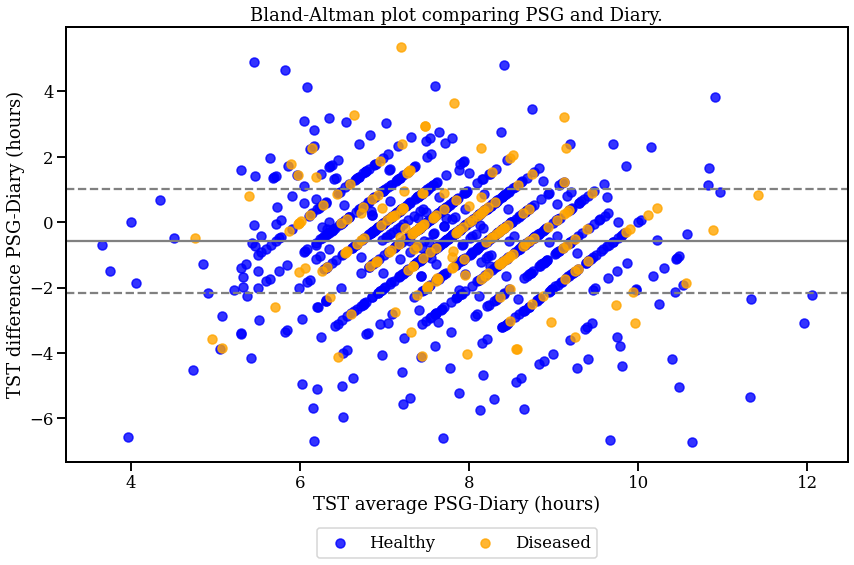

In [7]:
# TODO: have different colors
plot_bland_altman_subsets("mesa_bland_altman_psg_diary.pdf", df_mesa30, "psg", "diary", "PSG", "Diary", 
                          sepcolumn="diseased", sepcolors=["blue", "orange"], 
                         legendlabels=["Healthy", "Diseased"])

0 False
1 True


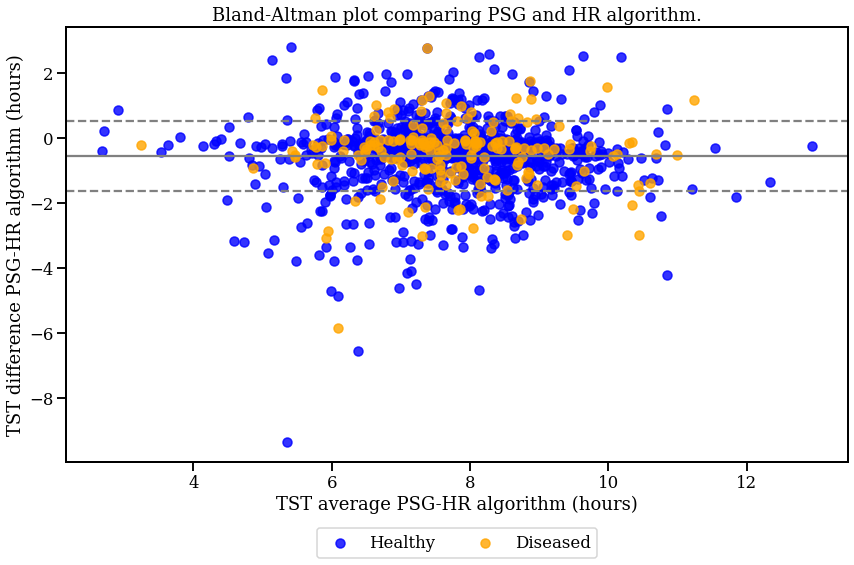

In [8]:
#plot_one_bland_altman(df_mesa30, "psg", "hr", "PSG", "HR")


# TODO: have different colors
plot_bland_altman_subsets("mesa_bland_altman_psg_hr.pdf", df_mesa30, "psg", "hr", "PSG", "HR algorithm", 
                          sepcolumn="diseased", sepcolors=["blue", "orange"], 
                         legendlabels=["Healthy", "Diseased"])

# Results for physionet apple watch 

In [9]:
#df_apple = pd.read_csv("./results/AppleWatch/results_apple_hr.csv.gz")
df_apple = pd.read_csv("./results/AppleWatch/results_apple_hr_best.csv.gz")
df_apple = dropnas(df_apple)
df_apple = transform_datetime(df_apple)

# Table 2 - HR part
print("-- Full dataset:")
calculate_table(df_apple, "psg_hr", labels=True)

calculate_table(df_apple, "psg_vanhees", labels=False)


-- Full dataset:
Comparing psg and hr
BEST parameters: Q: 0.80, W: 30.00, T: 360.00
TST: -23.23 \pm 0.42
MSE: 0.06 \pm 0.00
Cohens: 0.67 \pm 0.00
ONSET: 15.12 \pm 0.16
OFFSET: -8.10 \pm 0.39
Comparing psg and vanhees
44.39 \pm 1.30
0.12 \pm 0.00
0.71 \pm 0.00
-21.77 \pm 0.96
22.61 \pm 1.00


In [10]:
df_apple_vanhees = pd.read_csv("./results/AppleWatch/results_apple_vanhees.csv.gz")
df_apple_vanhees = dropnas(df_apple_vanhees)
df_apple_vanhees = transform_datetime(df_apple_vanhees)

calculate_table(df_apple_vanhees, "psg_vanhees", labels=True)

Comparing psg and vanhees
BEST parameters: Q: 0.42, W: 27.50, T: 360.00
TST: -13.89 \pm 0.37
MSE: 0.04 \pm 0.00
Cohens: 0.82 \pm 0.00
ONSET: 3.94 \pm 0.12
OFFSET: -9.94 \pm 0.36


# Results for MMASH

In [11]:
# MMASH: hr, vanhees, diary
#df_mmash = pd.read_csv("./results/MMASH/results_MMASH_HR.csv.gz")
df_mmash = pd.read_csv("./results/MMASH/results_MMASH_best.csv.gz")
df_mmash = dropnas(df_mmash, subset=["onset_diary", "offset_diary"])
df_mmash = transform_datetime(df_mmash)

# Table 2 - HR part
print("-- Full dataset:")
calculate_table(df_mmash, "diary_hr", labels=True)
calculate_table(df_mmash, "diary_vanhees", labels=False)


-- Full dataset:
Comparing diary and hr
BEST parameters: Q: 0.35, W: 32.50, T: 240.00
TST: -14.08 \pm 1.26
MSE: 0.07 \pm 0.00
Cohens: 0.85 \pm 0.00
ONSET: -15.75 \pm 0.68
OFFSET: -29.83 \pm 0.97
Comparing diary and vanhees
-60.17 \pm 1.18
0.08 \pm 0.00
0.83 \pm 0.00
15.13 \pm 0.62
-45.04 \pm 1.08


In [12]:
df_mmash_vanhees = pd.read_csv("./results/MMASH/results_MMASH_vanhees.csv.gz")
df_mmash_vanhees = dropnas(df_mmash_vanhees, subset=["onset_diary", "offset_diary"])
df_mmash_vanhees = transform_datetime(df_mmash_vanhees)
print("Z-ANGLE")
calculate_table(df_mmash_vanhees, "diary_vanhees", labels=True)
print('-'*40)
print("PITCH AND ROLL")
calculate_table(df_mmash_vanhees, "diary_vanheespr", labels=True)
get_mse(df_mmash_vanhees, ["mse_diary_vanheespr"])

Z-ANGLE
Comparing diary and vanhees
BEST parameters: Q: 0.40, W: 42.50, T: 60.00
TST: -44.94 \pm 1.16
MSE: 0.06 \pm 0.00
Cohens: 0.86 \pm 0.00
ONSET: 0.91 \pm 0.42
OFFSET: -44.02 \pm 0.97
----------------------------------------
PITCH AND ROLL
Comparing diary and vanheespr
BEST parameters: Q: 0.40, W: 35.00, T: 60.00
TST: -51.45 \pm 1.05
MSE: 0.06 \pm 0.00
Cohens: 0.88 \pm 0.00
ONSET: 7.40 \pm 0.25
OFFSET: -44.06 \pm 0.97


,mse_diary_vanheespr,quantile,window_lengths,time_merge_blocks
exp_id,,,,
1007,0.055966,0.400,35.0,60
941,0.055966,0.375,35.0,60
875,0.055966,0.350,35.0,60
1073,0.056010,0.425,35.0,60
413,0.056057,0.175,35.0,60
...,...,...,...,...
2201,0.666119,0.850,50.0,60
2202,0.666119,0.850,25.0,120
2203,0.666119,0.850,27.5,120


# Results for BBVS

In [13]:
df_bbvs_hr_fullday = pd.read_csv("./results/BBVS/results_BBVS_HR_fullday.csv.gz")
df_bbvs_hr_fullday[df_bbvs_hr_fullday["onset_diary"] == df_bbvs_hr_fullday["offset_diary"]]
get_mse(df_bbvs_hr_fullday, results=["mse_diary_hr"]).head() 



,mse_diary_hr,quantile,window_lengths,time_merge_blocks
exp_id,,,,
407,0.063355,0.500,50.0,60
406,0.064370,0.500,47.5,60
270,0.064798,0.450,37.5,60
339,0.064864,0.475,45.0,60
341,0.065020,0.475,50.0,60


In [14]:
df_bbvs_hr_night = pd.read_csv("./results/BBVS/results_BBVS_HR_night.csv.gz")
df_bbvs_hr_night[df_bbvs_hr_night["onset_diary"] == df_bbvs_hr_night["offset_diary"]]
get_mse(df_bbvs_hr_night, results=["mse_diary_hr"]).head() 

,mse_diary_hr,quantile,window_lengths,time_merge_blocks
exp_id,,,,
407,0.063355,0.500,50.0,60
406,0.064370,0.500,47.5,60
270,0.064798,0.450,37.5,60
339,0.064864,0.475,45.0,60
341,0.065020,0.475,50.0,60


In [15]:
df_bbvs_vanhees_dw = pd.read_csv("./results/BBVS/results_BBVS_vanhees_dw.csv.gz")

# TODO: detected problem for PID BVS069B
df_bbvs_vanhees_dw[df_bbvs_vanhees_dw["onset_diary"] == df_bbvs_vanhees_dw["offset_diary"]]

get_mse(df_bbvs_vanhees_dw, results=["mse_diary_vanhees"]).head() # 0.15	25.0	180 (0.068694)

,mse_diary_vanhees,quantile,window_lengths,time_merge_blocks
exp_id,,,,
155,0.068694,0.15,25.0,180
144,0.069279,0.15,25.0,120
156,0.069749,0.15,27.5,180
145,0.072577,0.15,27.5,120
157,0.072751,0.15,30.0,180


In [16]:
df_bbvs_vanhees_ndw = pd.read_csv("./results/BBVS/results_BBVS_vanhees_ndw.csv.gz")
get_mse(df_bbvs_vanhees_dw, results=["mse_diary_vanhees"]).head() # 0.15	25.0	180 (0.074094)

,mse_diary_vanhees,quantile,window_lengths,time_merge_blocks
exp_id,,,,
155,0.068694,0.15,25.0,180
144,0.069279,0.15,25.0,120
156,0.069749,0.15,27.5,180
145,0.072577,0.15,27.5,120
157,0.072751,0.15,30.0,180


In [18]:
df_bbvs_vanhees_thigh = pd.read_csv("./results/BBVS/results_BBVS_vanhees_thigh.csv.gz")
get_mse(df_bbvs_vanhees_thigh, results=["mse_diary_vanhees"]).head() # 0.10	25.0	180 (0.132125)

,mse_diary_vanhees,quantile,window_lengths,time_merge_blocks
exp_id,,,,
100,0.132125,0.10,25.0,180
101,0.136878,0.10,27.5,180
89,0.139231,0.10,25.0,120
133,0.139611,0.15,25.0,90
145,0.141491,0.15,27.5,120


In [37]:
df_bbvs_everything = pd.read_csv("./results_BBVS_everything.csv.gz")
df_bbvs_everything[df_bbvs_everything["onset_diary"] == df_bbvs_everything["offset_diary"]]
get_mse(df_bbvs_everything, results=["mse_diary_hrnight", "mse_diary_hrfullday"]).head() 



,mse_diary_hrnight,mse_diary_hrfullday,quantile,window_lengths,time_merge_blocks
exp_id,,,,,
1,0.155023,0.050964,0.5,50,60


# Please ignore the rest of this file

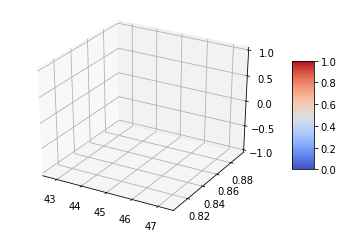

In [87]:
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

#X = df.groupby("exp_id")[["time_merge_blocks"]].mean() 
X = df.groupby("exp_id")[["window_lengths"]].mean() # 
Y = df.groupby("exp_id")[["quantile"]].mean()
Z = df.groupby("exp_id")[["mse_psg_hr"]].mean()
res = pd.concat([X,Y,Z], axis=1).groupby(["window_lengths", "quantile"]).mean().reset_index()
X = res[["window_lengths"]].values
Y = res[["quantile"]].values
Z = res[["mse_psg_hr"]].values

#X, Y = np.meshgrid(X, Y)


ax.set_zlim(-1.01, 1.01)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
mse_results = get_mse(df, results=["mse_diary_hr"])
myfilter(mse_results, 0.45, 40.0, 60)

In [ ]:
get_mse(df_full, results=["mse_psg_hr"]).head()

In [ ]:
time_deviation(df_full, "onset_hr", "onset_psg")
time_deviation(df_full, "offset_hr", "offset_psg")

In [ ]:
from matplotlib import cm
fig = plt.figure()
ax = fig.gca(projection='3d')

#X = df.groupby("exp_id")[["time_merge_blocks"]].mean() 
X = df.groupby("exp_id")[["window_lengths"]].mean() # 
Y = df.groupby("exp_id")[["quantile"]].mean()
Z = df.groupby("exp_id")[["mse_psg_hr"]].mean()
res = pd.concat([X,Y,Z], axis=1).groupby(["window_lengths", "quantile"]).mean().reset_index()
X = res[["window_lengths"]].values
Y = res[["quantile"]].values
Z = res[["mse_psg_hr"]].values

#X, Y = np.meshgrid(X, Y)


ax.set_zlim(-1.01, 1.01)
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=1, antialiased=False)

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:
cohens_exp_ids = cohen_results.sort_values(by="cohens", ascending=False).head(50)
cohens_exp_ids

In [ ]:
df_exp = df[df["exp_id"] == 394] # .sort_values(by="mse", ascending=False).head(50)

In [ ]:
# def load_mesa_old():
#     df1 = pd.read_csv("./results/results_MESA_hr_1.csv.gz").reset_index()
#     df2 = pd.read_csv("./results/results_MESA_hr_2.csv.gz").reset_index()
#     df2["exp_id"] += (df1["exp_id"].max() + 1)
#     df3 = pd.read_csv("./results/results_MESA_hr_3.csv.gz").reset_index()
#     df3["exp_id"] += (df2["exp_id"].max() + 1)
#     df4 = pd.read_csv("./results/results_MESA_hr_4.csv.gz").reset_index()
#     df4["exp_id"] += (df3["exp_id"].max() + 1)
#     df5 = pd.read_csv("./results/results_MESA_hr_5.csv.gz").reset_index()
#     df5["exp_id"] += (df4["exp_id"].max() + 1)
    
#     return pd.concat([df1,df2,df3,df4,df5], axis=0)

#df = pd.read_csv("./results/HRalgo_new.csv")
#df = pd.read_csv("./results/results_BBVS_vanhees.csv.gz")
#df = pd.read_csv("./results/results_BBVS_hr.csv.gz")
#df = pd.read_csv("./results/results_BBVS_HR_fullday.csv.gz")
#df = load_mesa()
#df2 = pd.read_csv("./results/results_MESA_hr_1.csv.gz").reset_index()
#df = pd.read_csv("./results/results_apple_hr.csv.gz")
#df2 = pd.read_csv("./results/results_MESA_hr_new.csv.gz")
#df3 = pd.read_csv("./results_MESA_hr.csv.gz")

#df = myfilter(df2, 0.525, 27.5, 60)
#df[df["pid"] == 4723]

In [5]:
# # Table 2 - HR part
# def calculate_table2_mesa_hr(df_mesa):
#     best_exp = get_mse(df_mesa, results=["mse_psg_hr"]).head(1)
#     Q, W, T = get_hparams(best_exp)

#     best = myfilter(df_mesa30, Q, W, T).copy()

#     best["tst_hr"] = best["offset_hr"] - best["onset_hr"]
#     best["tst_psg"] = best["offset_psg"] - best["onset_psg"]

#     print("TST: %.2f \pm %.2f" % time_deviation(best, "tst_hr", "tst_psg"))
#     print("MSE: %.2f \pm %.2f" % ci95(best["mse_psg_hr"].values))
#     print("Cohens: %.2f \pm %.2f" % ci95(best["cohens_psg_hr"].values))

#     print("ONSET: %.2f \pm %.2f" % time_deviation(best, "onset_hr", "onset_psg"))
#     print("OFFSET: %.2f \pm %.2f" % time_deviation(best, "offset_hr", "offset_psg"))

# print("-- Full dataset:")
# calculate_table2_mesa_hr(df_mesa30)
# print(40*'-')
# print("-- Diseased participants:")
# calculate_table2_mesa_hr(df_mesa30_diseased)
# print(40*'-')
# print("-- Healthy participants:")
# calculate_table2_mesa_hr(df_mesa30_healthy)
# print(40*'-')


In [ ]:
# Table 2 - Diary part
df_mesa30_diary = pd.merge(df_mesa30,
                           mesa[["mesaid", "bedtmwkday5c", "bedtmwkend5c", "waketmwkday5c", "waketmwkend5c"]],
                           left_on="pid", right_on="mesaid")

def create_fake_sleep_on_off_set(timein, weekday, weekend):
    
    is_it_weekday = timein.weekday() in [4, 5]
    day = timein.day
    if is_it_weekday:
        day0 = "2017-01-%02d %s" % (day - 1 if day-1 > 0 else day, weekend)
        day1 = "2017-01-%02d %s" % (day, weekend)
        day2 = "2017-01-%02d %s" % (day+1, weekend)
    else:
        day0 = "2017-01-%02d %s" % (day - 1 if day-1 > 0 else day, weekday)
        day1 = "2017-01-%02d %s" % (day, weekday)
        day2 = "2017-01-%02d %s" % (day+1, weekday)
    
    day0 = datetime.strptime(day0, '%Y-%m-%d %H:%M:%S')
    day1 = datetime.strptime(day1, '%Y-%m-%d %H:%M:%S')
    day2 = datetime.strptime(day2, '%Y-%m-%d %H:%M:%S')
    
    possibilities = [day0, day1, day2]
    results = [abs(timein - day0), abs(timein - day1), abs(timein - day2)]

    return possibilities[np.argmin(results)]

    
df_mesa30_diary["onset_diary"] = df_mesa30_diary[["onset_psg", "bedtmwkday5c", "bedtmwkend5c"]].apply(lambda x:
        create_fake_sleep_on_off_set(x["onset_psg"], x["bedtmwkday5c"], x["bedtmwkend5c"]), axis=1)

df_mesa30_diary["offset_diary"] = df_mesa30_diary[["offset_psg", "waketmwkday5c", "waketmwkend5c"]].apply(lambda x:
        create_fake_sleep_on_off_set(x["offset_psg"], x["waketmwkday5c"], x["waketmwkend5c"]), axis=1)

